# Initialisation

In [26]:
%matplotlib inline
import os
import glob
import time
import numpy as np
from re import search, match
from PIL import Image

from scipy import ndimage as ndi # use for binary_fill_holes
from skimage import morphology # use for remove small objects
from pprint import pprint

from scipy import ndimage, misc
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_local

from skimage.measure import regionprops
import skimage.measure as skmeas
#from skimage.external import tifffile as tiff

# plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (8,8)

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.transform import (hough_line, hough_line_peaks)
from scipy.stats import mode
from skimage import io
from skimage.filters import threshold_otsu, sobel
from matplotlib import cm
import os
import shutil
import math

In [2]:
def AutoRotate(image):
    binary_image = (image>threshold_otsu(image)).astype(int)
    vertical_mean = np.sum(binary_image,axis=1)
    image_edges = sobel(binary_image)
    h, theta, d = hough_line(image_edges)
    accum, angles, dists = hough_line_peaks(h, theta, d)
    angle = np.rad2deg(mode(angles)[0][0])
    
    if (angle < 0):
        angle = angle + 90
    
    else:
        angle = angle - 90

    if np.sum(vertical_mean[:len(vertical_mean)//2])>np.sum(vertical_mean[len(vertical_mean)//2:]):
        return angle+180

    return angle

In [3]:
def AutoCrop(image):
    binary_image = (image>threshold_otsu(image))
    return np.where(np.mean(binary_image,axis=0)<0.2)[0][1]+1,np.where(np.mean(binary_image,axis=0)<0.2)[0][-1]-1

In [4]:
def rotatedRectWithMaxArea(w, h, angle):
    
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.
    """
    if w <= 0 or h <= 0:
        return 0,0

    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr,hr

In [5]:
def crop_around_center(image,angle):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """
    
    angle = angle*np.pi/180
    initial_width,initial_height = image.shape
    width,height = rotatedRectWithMaxArea(initial_width,initial_height,angle)
    #image = rotate(image,angle)

    width = int(np.ceil(width))
    height = int(np.ceil(height))
    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)
    cropped_image = image[:,x1:x2]
    y1,y2 = np.where(np.all(cropped_image,axis=1))[0][0],np.where(np.all(cropped_image,axis=1))[0][-1]
    
    ## Removing incomplete channels
    
    image_rc = image[y1:y2, x1:x2]
    binary_global = image_rc>threshold_otsu(image_rc)
    
    x1_new = (np.where(np.diff(np.sign((np.mean(binary_global,0)<0.1).astype('int')))<0)[0][0]+x1)/2
    if np.abs(x1-x1_new)<10:
        x1_new = np.where(np.diff(np.sign((np.mean(binary_global,0)<0.1).astype('int')))<0)[0][1]-15
    x2_new = (np.where(np.diff(np.sign((np.mean(binary_global,0)<0.1).astype('int')))>0)[0][-1]+x2)/2
    if np.abs(x2_new-x2)<10:
        x2_new = np.where(np.diff(np.sign((np.mean(binary_global,0)<0.1).astype('int')))>0)[0][-2]+15

    y1_new = np.max([np.where(np.mean(binary_global,1)>0)[0][0]-15,0])
    y2_new = np.min([np.where(np.mean(binary_global,1)>0)[0][-1]+15,y2])
    #x1,x2 = np.where(binary_global<0.1)[0][0],np.where(binary_global<0.1)[0][-1]
    return image_rc[y1_new:y2_new, x1_new:x2_new],(slice(y1+y1_new,y1+y2_new),slice(x1+x1_new,x1+x2_new))

In [6]:
def AutoDetect(image,rot90=0):
    image_rotated = rotate(image,AutoRotate(image)+90*rot90)
    cropped_image = crop_around_center(image_rotated,AutoRotate(image))[0]
    return cropped_image,crop_around_center(image_rotated,AutoRotate(image))[1],AutoRotate(image)

In [7]:
def find_channels(image,error=10,channel_threshold=0.1):
    binary_global = (image>threshold_otsu(image)).astype(int)
    channel_intensity = np.median(np.sum(binary_global,axis=1))
    vertical_mean = np.sum(binary_global,axis=1)
    allowed_rows = []
    for ix,row in enumerate(vertical_mean):
        if abs(row-channel_intensity)<error:
            allowed_rows.append(ix)
        
    allowed_rows = np.array(allowed_rows)
    
    lower_row,upper_row = np.min(allowed_rows),np.max(allowed_rows)
    horizontal_mean = np.mean(binary_global,axis=0)>channel_threshold
    cross_section = (np.mean(binary_global,axis=0)>0.1).astype(int)-.5
    crossings = np.where(np.diff(np.sign(cross_section)))[0]
    sections = list(map(list,np.dstack((crossings[0::2],crossings[1::2])).reshape(-1,2)))
    return sections,(lower_row,upper_row)

In [10]:

def find_all_cells(image,img_start=10,img_end=400,offset = -40000,threshold = 100):
    cells = []
    #offset = -np.average(np.mean(image[img_start:img_end],axis=1))
    #cross_section = np.mean(image[img_start:img_end],axis=1)+offset
    offset = -np.average(np.mean(image,axis=1))
    cross_section = np.mean(image,axis=1)+offset
    cross_section = -cross_section-threshold
#     plt.plot(cross_section)
#     plt.plot(np.linspace(img_start,img_end,10),np.repeat(0,10))
    crossings = np.where(np.diff(np.sign(cross_section)))[0]
    sections = list(map(tuple,np.dstack((crossings[:-1],crossings[1:])).reshape(-1,2)))
    
    for section in sections:
        #if np.any(cross_section[section[0]:section[1]]>threshold) and section[1]-section[0]>20:
         if np.sum(cross_section[section[0]:section[1]])>0 and section[1]-section[0]>20:
                cells.append(section)
    
    cells = merge_sections(cells)
    return cells

def merge_sections(sections,distance = 20):
    merged_section = []
    i = 0
    while i < len(sections):
        if i == len(sections)-1:
            merged_section.append(sections[i])
            break
        if sections[i+1][0]-sections[i][1]<distance:
            merged_section.append((sections[i][0],sections[i+1][1]))
            i=i+2
        else:
            merged_section.append(sections[i])
            i = i+1
        
    return merged_section



# Analysis

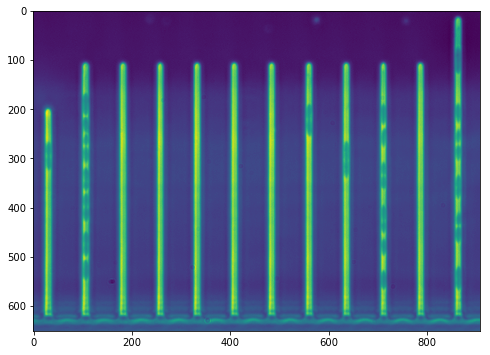

In [9]:
channel_number = 9
imPIL = Image.open('/Volumes/Experiment/2022-07-01-1306/Camera 00/Position '+str(channel_number).zfill(3)+'/Frame '+str(0).zfill(5)+'.tif')

image = np.asarray(imPIL)
plt.imshow(AutoDetect(image,1)[0])

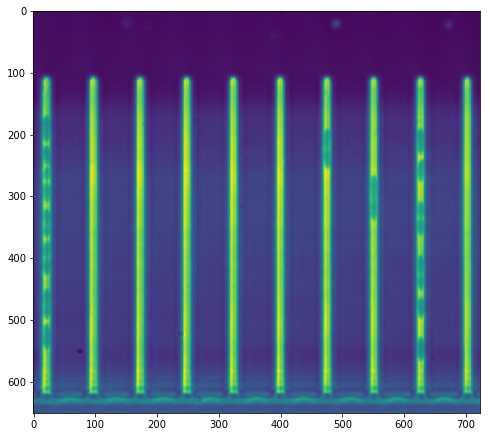

In [38]:
plt.imshow(AutoDetect(image,1)[0][:,85:808])

In [28]:
AutoDetect(image,1)[1]

(slice(218, 869, None), slice(76, 984, None))

# Rough

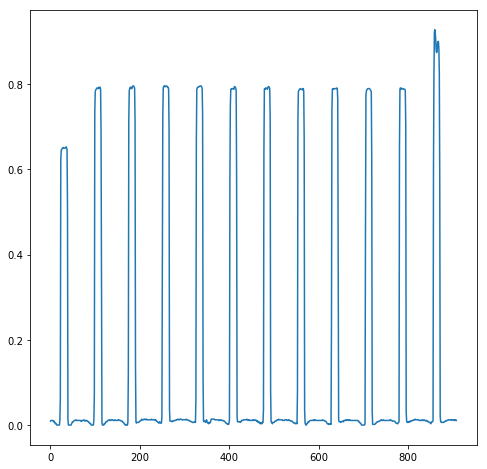

In [11]:
binary_image = AutoDetect(image,1)[0]>threshold_otsu(AutoDetect(image,1)[0])
plt.plot(np.mean(binary_image,0))

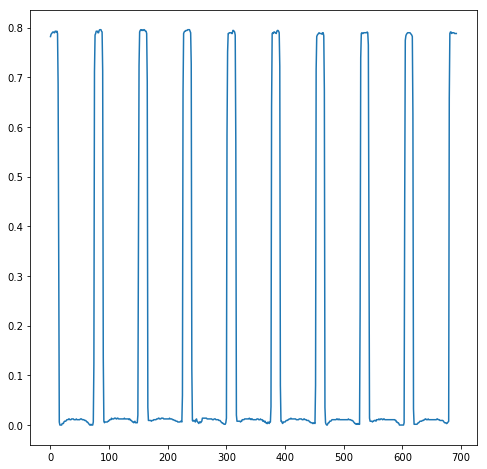

In [42]:
plt.plot(np.mean(binary_image,0)[100:793])

In [45]:
all_channels = np.mean(binary_image,0)[100:793]
np.sum(np.diff(all_channels)<-0.5)

7

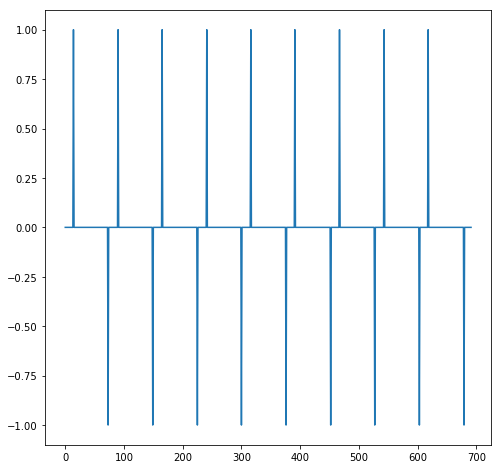

In [60]:
plt.plot(np.diff((all_channels<0.1).astype(np.int16)))

In [53]:
(np.sum(all_channels<0.1)+3)/np.sum(np.diff(all_channels)<-0.5)

77

In [56]:
int(240./7)

34

In [99]:
import numpy as np
m = np.load('/Users/dataanalysis/Documents/2022_March/Analysis/Position 14/Position 14.npy',allow_pickle=True,encoding='latin1')

In [100]:
m[0][1]

[(92, 141)]

In [4]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

In [105]:
56/1.5

37.333333333333336

In [7]:
plt.imshow(image[35:250:,85:100])
plt.axis('off')

(-0.5, 14.5, 214.5, -0.5)

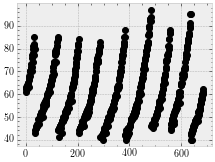

In [101]:
j=4
length = [m[i][j][0][1]-m[i][j][0][0] for i in range(1000) if len(m[i][2])>0]
length = np.array(length)
plt.plot(length,'ko')

In [103]:
factor = 0.023*1.5

In [44]:
plt.style.use('bmh')


In [104]:
for j in range(800):
    f,(a0,a1) = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios':[1,4]})
    imPIL = Image.open('/Users/dataanalysis/Documents/2022_March/Analysis/Position 14/images_4/'+str(j)+'.png')
    image = np.asarray(imPIL)
    a0.imshow(image[0:500,100:147])
    a0.axis('off')
    a1.plot(factor*length[:j+1],'bo',alpha=0.3)
    a1.set_ylabel(r'Length ($\mu m$)')
    a1.set_xlabel(r'Time (min)')
    a1.set_xlim(-20,820)
    a1.set_ylim(.5,3.5)
    plt.savefig('/Users/dataanalysis/Documents/2022_March/Analysis/Position 14/Video/'+str(j)+'.png')
    plt.close()

(-0.5, 46.5, 499.5, -0.5)

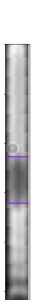

In [97]:
plt.figure(figsize=(0.5,6))
imPIL = Image.open('/Users/dataanalysis/Documents/2022_March/Analysis/Position 14/images_4/'+str(j)+'.png')
image = np.asarray(imPIL)
plt.imshow(image[0:500,100:147])
#plt.imshow(image[60:400,110:140])
plt.axis('off')

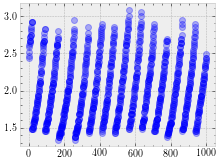

In [68]:
plt.plot(factor*length,'bo',alpha=0.3)